# Preparación del entorno
### 1.1 Configuraión inicial

In [ ]:
# Instalación de paquetes necesarios
# ! pip install tensorflow pandas numpy matplotlib seaborn scikit-learn
pip install sdv

# Importación de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


### 1.2 Carga y Exploración Inicial de Datos

Forma del dataset: (545, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB
None
              price          area    bedrooms   bathrooms     stories  \
count  5.450000e+02    545.000000  545.000000  

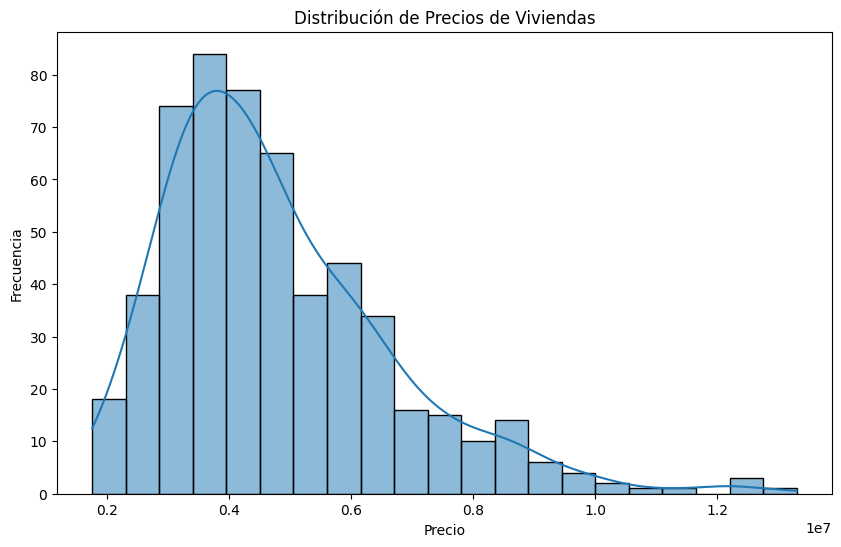

In [74]:
# Cargar el dataset
df = pd.read_csv('Housing.csv')

# Exploración inicial
print(f"Forma del dataset: {df.shape}")
print(df.info())
print(df.describe())

# Verificar valores nulos
print(f"Valores nulos por columna:\n{df.isnull().sum()}")

# Visualizar la distribución del precio
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True)
plt.title('Distribución de Precios de Viviendas')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()


In [122]:
! conda install -c conda-forge sdv

^C


In [ ]:
from sdv.tabular import CTGAN


# Especificar las columnas categóricas, si es necesario
categorical_columns = ['mainroad', 'guestroom', 'basement', 
                       'hotwaterheating', 'airconditioning', 'prefarea', 
                       'furnishingstatus']

# Crear el modelo CTGAN. Puedes ajustar 'epochs' y otros parámetros según tu dataset.
ctgan_model = CTGAN(epochs=300, categorical_columns=categorical_columns)

# Entrenar CTGAN con el dataset original
ctgan_model.fit(df)

# Generar datos sintéticos, por ejemplo, 1000 registros nuevos
synthetic_data = ctgan_model.sample(500)

# Visualizar las primeras filas de los datos sintéticos generados
print(synthetic_data.head())


ImportError: cannot import name 'CTGAN' from 'sdv' (c:\Users\Alumno_AI\.conda\envs\house_model\lib\site-packages\sdv\__init__.py)

## 2 Análisis Exploratorio de Datos (EDA)
### 2.1 Análisis de Correlaciones

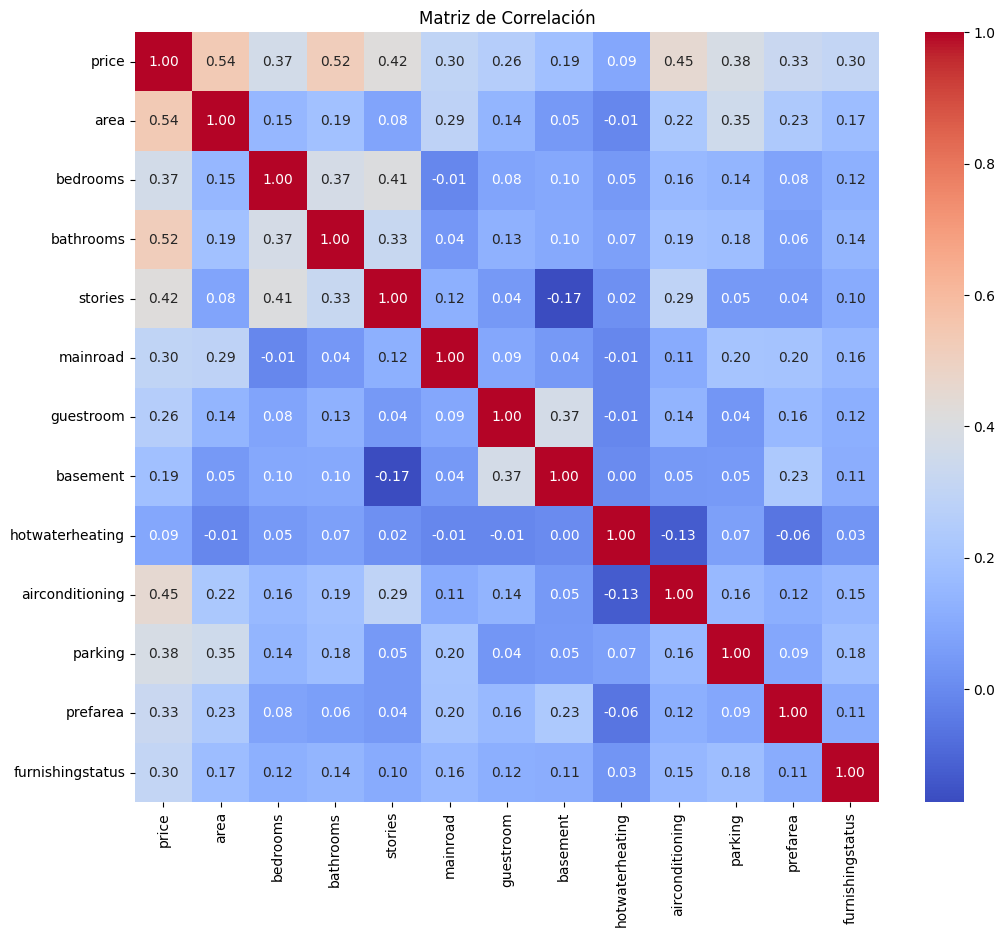

In [75]:
# Convertir variables categóricas a numéricas para análisis
df_numeric = df.copy()
categorical_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 
                    'airconditioning', 'prefarea', 'furnishingstatus']

# Codificación básica para visualización
for col in categorical_cols:
    if col != 'furnishingstatus':
        df_numeric[col] = df_numeric[col].map({'yes': 1, 'no': 0})
    else:
        df_numeric[col] = df_numeric[col].map({'unfurnished': 0, 'semi-furnished': 1, 'furnished': 2})

# Matriz de correlación
plt.figure(figsize=(12, 10))
corr_matrix = df_numeric.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()


### 2.2 Análisis de Variables Categóricas

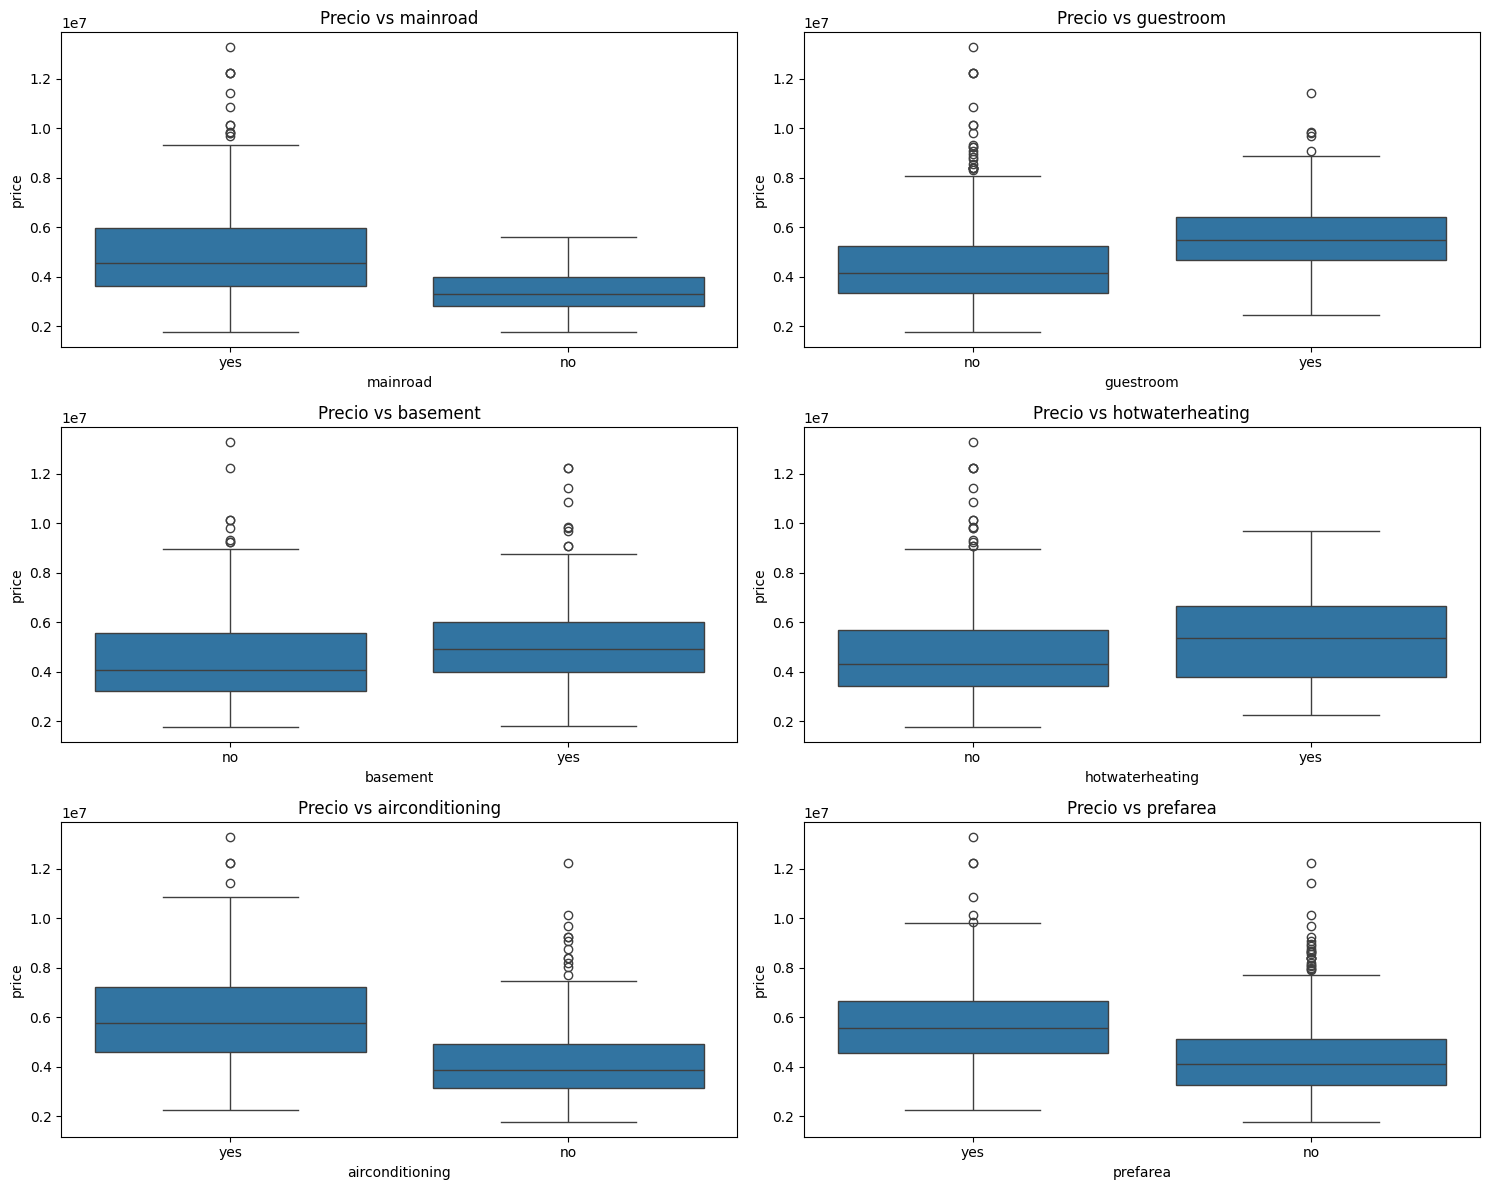

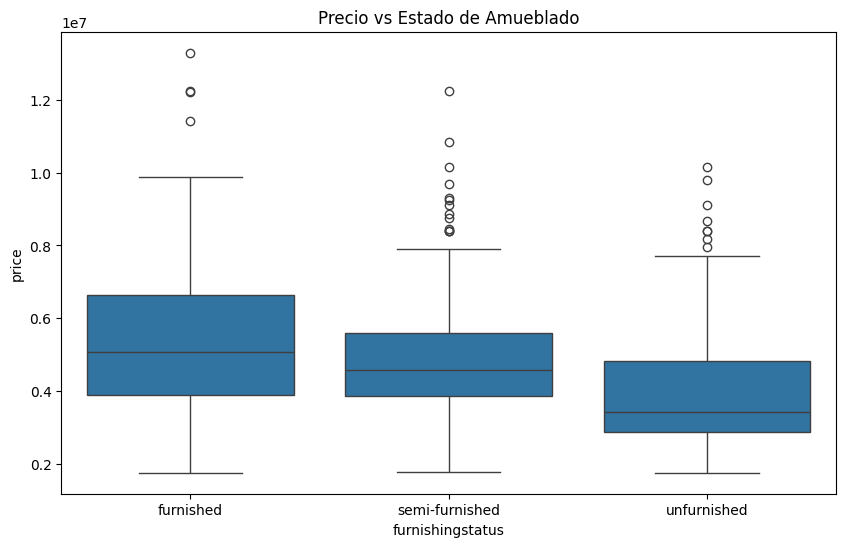

In [76]:
# Visualizar la relación entre variables categóricas y precio
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

categorical_binary = ['mainroad', 'guestroom', 'basement', 
                      'hotwaterheating', 'airconditioning', 'prefarea']

for i, cat_var in enumerate(categorical_binary):
    sns.boxplot(x=cat_var, y='price', data=df, ax=axes[i])
    axes[i].set_title(f'Precio vs {cat_var}')

plt.tight_layout()
plt.show()

# Analizar furnishingstatus
plt.figure(figsize=(10, 6))
sns.boxplot(x='furnishingstatus', y='price', data=df)
plt.title('Precio vs Estado de Amueblado')
plt.show()


### 2.3 Análisis de Variables Numéricas

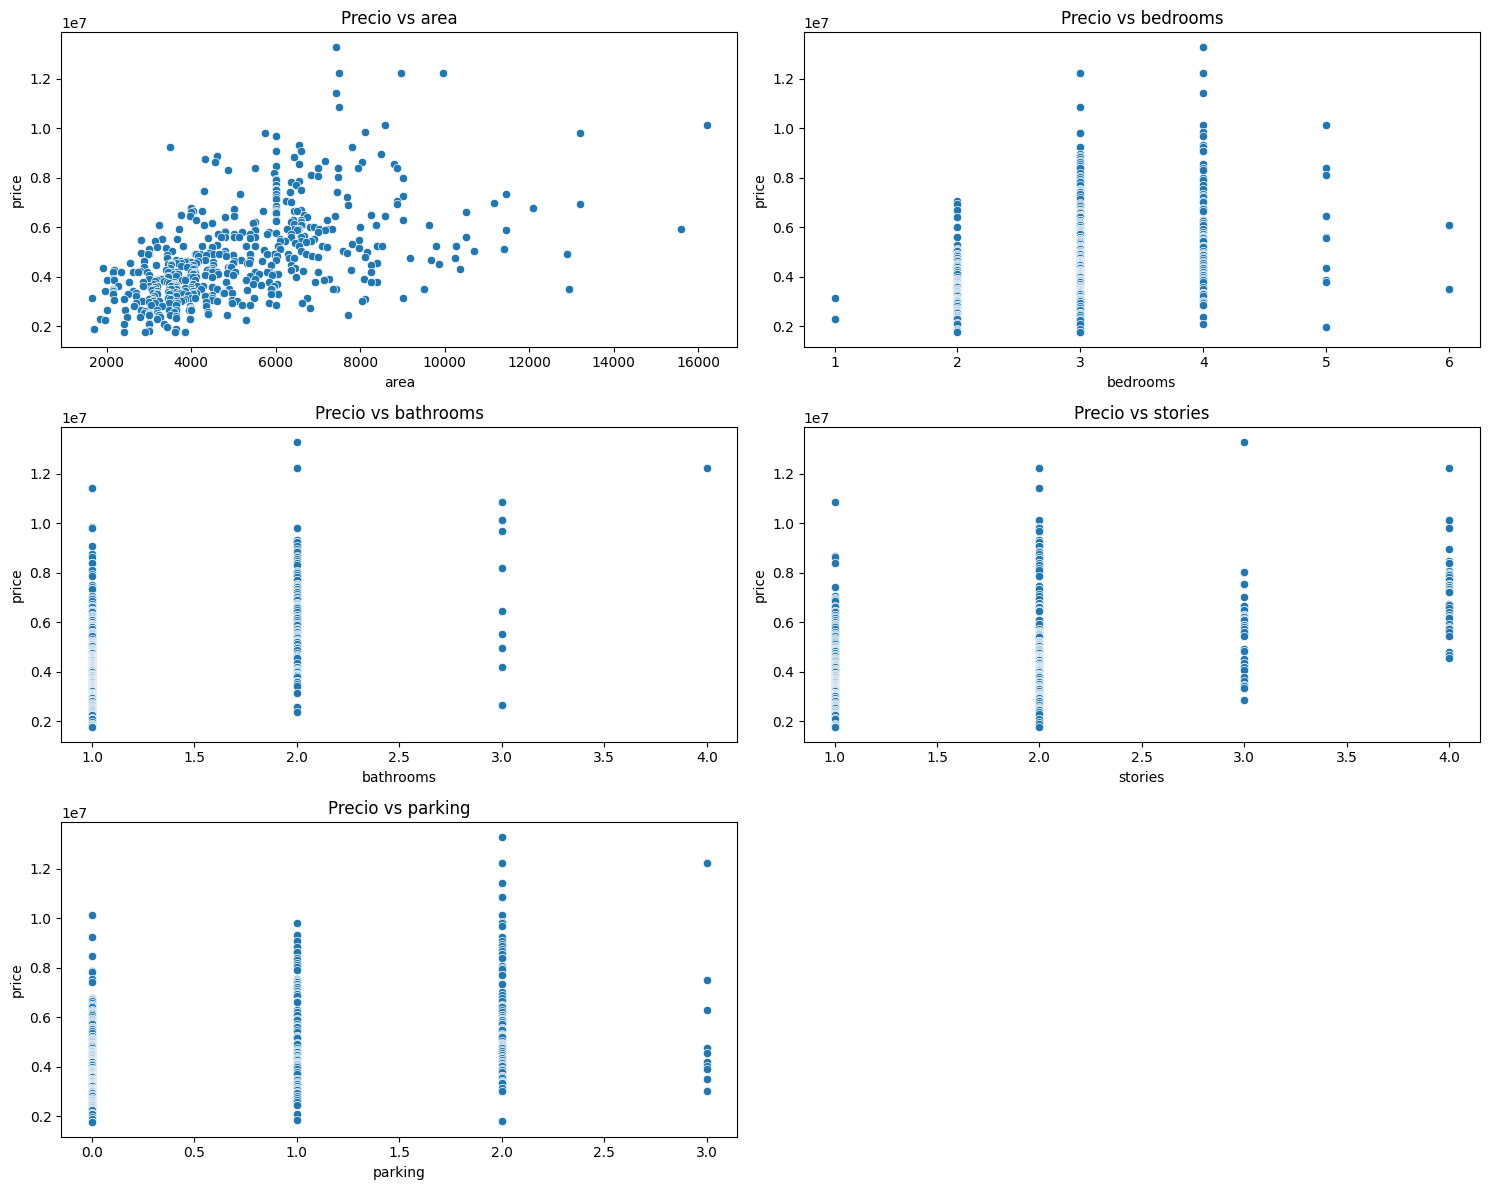

In [77]:
# Visualizar relaciones entre variables numéricas y precio
numeric_features = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    if i < len(axes):
        sns.scatterplot(x=feature, y='price', data=df, ax=axes[i])
        axes[i].set_title(f'Precio vs {feature}')

# Eliminar ejes sobrantes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## 3. Preprocesamiento de Datos
## 3.1 División del Dataset

In [78]:
# Separar características y variable objetivo
X = df.drop('price', axis=1)
y = df['price']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### 3.2 Transformación de Variables

In [96]:
# %% Preparación y Preprocesamiento Mejorado

# Separar características y variable objetivo
X = df.drop('price', axis=1)
y = df['price']

# Dividir en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear nuevas características basadas en relaciones observadas
# Evitar división por cero sumando 1 en el denominador
X_train['area_per_bedroom'] = X_train['area'] / (X_train['bedrooms'] + 1)
X_test['area_per_bedroom'] = X_test['area'] / (X_test['bedrooms'] + 1)

X_train['bathrooms_per_bedroom'] = X_train['bathrooms'] / (X_train['bedrooms'] + 1)
X_test['bathrooms_per_bedroom'] = X_test['bathrooms'] / (X_test['bedrooms'] + 1)

X_train['area_per_story'] = X_train['area'] / (X_train['stories'] + 1)
X_test['area_per_story'] = X_test['area'] / (X_test['stories'] + 1)

# Definir las listas de características según su tipo
continuous_features = ['area', 'bathrooms', 'area_per_bedroom', 'bathrooms_per_bedroom', 'area_per_story']
discrete_features = ['bedrooms', 'stories', 'parking']
categorical_features = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
ordinal_features = ['furnishingstatus']

# Categorías para la variable ordinal
ordinal_categories = [['unfurnished', 'semi-furnished', 'furnished']]

# Transformación logarítmica personalizada para variables continuas y el target
import numpy as np
from sklearn.preprocessing import FunctionTransformer

def log_transform(x):
    return np.log(x + 1)

# Importar los transformadores necesarios
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Pipeline para variables continuas: imputación -> log_transform -> escalado robusto
continuous_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('log_transform', FunctionTransformer(log_transform)),
    ('scaler', RobustScaler())
])

# Pipeline para variables discretas (contadores): imputación -> escalado robusto
discrete_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# Pipeline para variables categóricas: imputación -> One-Hot Encoding (drop first para evitar multicolinealidad)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first'))
])

# Pipeline para variables ordinales: imputación -> codificación ordinal
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(
        categories=ordinal_categories,
        handle_unknown='use_encoded_value',
        unknown_value=-1
    ))
])

# Combinar todos los pipelines en un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cont', continuous_transformer, continuous_features),
        ('disc', discrete_transformer, discrete_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features)
    ]
)

# Aplicar transformaciones al conjunto de entrenamiento y prueba
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Preprocesamiento de la variable objetivo (price)
# Aplicar log-transform para reducir la asimetría y luego escalar
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train_log.values.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test_log.values.reshape(-1, 1)).flatten()

print(f"Forma de X_train_processed: {X_train_processed.shape}")


Forma de X_train_processed: (436, 15)


## 4 Construcción del Modelo con TensorFlow
### 4.1 Modelo Básico de Red Neuronal

In [103]:
import tensorflow as tf
from tensorflow.keras import regularizers

# Determinar el número de características tras el preprocesamiento
num_features = X_train_processed.shape[1]

def build_model():
    model = tf.keras.Sequential([
        # Capa densa con regularización L2 para reducir overfitting y Dropout para mayor robustez
        tf.keras.layers.Dense(64, activation='relu', 
                              kernel_regularizer=regularizers.l2(0.001), 
                              input_shape=(num_features,)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu', 
                              kernel_regularizer=regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1)  # Capa de salida para regresión (sin activación)
    ])
    
    model.compile(optimizer='adam',
                  loss='mse',    # Error cuadrático medio
                  metrics=['mae'])  # Error absoluto medio
    
    return model

# Crear y resumir el modelo
model = build_model()
model.summary()


Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_166 (Dense)               │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_167 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_168 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_169 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,649 (14.25 KB)

 Trainable params: 3,649 (14.25 KB)

 Non-trainable params: 0 (0.00 B)

### 4.2 Entrenamiento del Modelo

Epoch 1/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - loss: 1.2759 - mae: 0.9756
Epoch 1: val_loss improved from inf to 1.00930, saving model to best_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1.0580 - mae: 0.8165 - val_loss: 1.0093 - val_mae: 0.7617 - learning_rate: 0.0010
Epoch 2/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7313 - mae: 0.5952
Epoch 2: val_loss improved from 1.00930 to 0.80875, saving model to best_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8525 - mae: 0.6810 - val_loss: 0.8087 - val_mae: 0.6711 - learning_rate: 0.0010
Epoch 3/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5076 - mae: 0.5170
Epoch 3: val_loss improved from 0.80875 to 0.64075, saving model to best_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6161 - mae: 0.5764 - val_loss: 0.6408 - val_mae: 0.5636 - learning_rate: 0.0010
Epoch 4/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3923 - mae: 0.4223
Epoch 4: val_loss improved from 0.64075 to 0.56957, saving model to best_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5616 - mae: 0.5365 - val_loss: 0.5696 - val_mae: 0.5286 - learning_rate: 0.0010
Epoch 5/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6874 - mae: 0.5578
Epoch 5: val_loss improved from 0.56957 to 0.54169, saving model to best_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5785 - mae: 0.5490 - val_loss: 0.5417 - val_mae: 0.5265 - learning_rate: 0.0010
Epoch 6/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3545 - mae: 0.4668
Epoch 6: val_loss improved from 0.54169 to 0.52285, saving model to best_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4703 - mae: 0.5148 - val_loss: 0.5229 - val_mae: 0.5232 - learning_rate: 0.0010
Epoch 7/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3530 - mae: 0.4037
Epoch 7: val_loss improved from 0.52285 to 0.51342, saving model to best_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4612 - mae: 0.4873 - val_loss: 0.5134 - val_mae: 0.5151 - learning_rate: 0.0010
Epoch 8/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.4823 - mae: 0.4946
Epoch 8: val_loss improved from 0.51342 to 0.51194, saving model to best_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4537 - mae: 0.4874 - val_loss: 0.5119 - val_mae: 0.5073 - learning_rate: 0.0010
Epoch 9/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3136 - mae: 0.3755
Epoch 9: val_loss improved from 0.51194 to 0.49988, saving model to best_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4197 - mae: 0.4668 - val_loss: 0.4999 - val_mae: 0.5038 - learning_rate: 0.0010
Epoch 10/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3493 - mae: 0.4177
Epoch 10: val_loss improved from 0.49988 to 0.48290, saving model to best_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4051 - mae: 0.4430 - val_loss: 0.4829 - val_mae: 0.4983 - learning_rate: 0.0010
Epoch 11/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.4339 - mae: 0.4547
Epoch 11: val_loss improved from 0.48290 to 0.48229, saving model to best_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4352 - mae: 0.4665 - val_loss: 0.4823 - val_mae: 0.4897 - learning_rate: 0.0010
Epoch 12/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.2822 - mae: 0.3380
Epoch 12: val_loss did not improve from 0.48229
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3742 - mae: 0.4034 - val_loss: 0.4856 - val_mae: 0.4887 - learning_rate: 0.0010
Epoch 13/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2201 - mae: 0.2964
Epoch 13: val_loss improved from 0.48229 to 0.47387, saving model to best_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4281 - mae: 0.4421 - val_loss: 0.4739 - val_mae: 0.4865 - learning_rate: 0.0010
Epoch 14/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3439 - mae: 0.4353
Epoch 14: val_loss improved from 0.47387 to 0.46099, saving model to best_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4002 - mae: 0.4476 - val_loss: 0.4610 - val_mae: 0.4867 - learning_rate: 0.0010
Epoch 15/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3679 - mae: 0.4283
Epoch 15: val_loss did not improve from 0.46099
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3906 - mae: 0.4371 - val_loss: 0.4622 - val_mae: 0.4820 - learning_rate: 0.0010
Epoch 16/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2031 - mae: 0.3013
Epoch 16: val_loss did not improve from 0.46099
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3464 - mae: 0.4072 - val_loss: 0.4627 - val_mae: 0.4815 - learning_rate: 0.0010
Epoch 17/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3556 - mae: 0.4735
Epoch 17: val_loss improved from 0.46099 to 0.45862, saving model to best_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3910 - mae: 0.4533 - val_loss: 0.4586 - val_mae: 0.4790 - learning_rate: 0.0010
Epoch 18/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3303 - mae: 0.4122
Epoch 18: val_loss improved from 0.45862 to 0.45549, saving model to best_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3993 - mae: 0.4525 - val_loss: 0.4555 - val_mae: 0.4781 - learning_rate: 0.0010
Epoch 19/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3512 - mae: 0.4185
Epoch 19: val_loss did not improve from 0.45549
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4078 - mae: 0.4502 - val_loss: 0.4569 - val_mae: 0.4762 - learning_rate: 0.0010
Epoch 20/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3211 - mae: 0.3427
Epoch 20: val_loss did not improve from 0.45549
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3617 - mae: 0.4089 - val_loss: 0.4558 - val_mae: 0.4747 - learning_rate: 0.0010
Epoch 21/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3599 - mae: 0.4071
Epoch 21: val_loss improved from 0.45549 to 0.44164, saving model to best_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3755 - mae: 0.4334 - val_loss: 0.4416 - val_mae: 0.4712 - learning_rate: 0.0010
Epoch 22/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.3228 - mae: 0.4071
Epoch 22: val_loss did not improve from 0.44164
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3493 - mae: 0.4064 - val_loss: 0.4449 - val_mae: 0.4705 - learning_rate: 0.0010
Epoch 23/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3080 - mae: 0.4209
Epoch 23: val_loss did not improve from 0.44164
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3967 - mae: 0.4509 - val_loss: 0.4431 - val_mae: 0.4674 - learning_rate: 0.0010
Epoch 24/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3999 - mae: 0.4409
Epoch 24: val_loss did not improve from 0.44164
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4044 - mae: 0.4416 - val_loss: 0.4465 - val_mae: 0.4685 - learning_rate: 0.0010
Epoch 25/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2886 - mae: 0.3958
Epoch 25:

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3530 - mae: 0.4243 - val_loss: 0.4395 - val_mae: 0.4653 - learning_rate: 5.0000e-04
Epoch 29/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.4300 - mae: 0.4645
Epoch 29: val_loss did not improve from 0.43952
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3723 - mae: 0.4306 - val_loss: 0.4410 - val_mae: 0.4646 - learning_rate: 5.0000e-04
Epoch 30/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3040 - mae: 0.4043
Epoch 30: val_loss did not improve from 0.43952
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3561 - mae: 0.4199 - val_loss: 0.4415 - val_mae: 0.4643 - learning_rate: 5.0000e-04
Epoch 31/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.4229 - mae: 0.4360
Epoch 31: val_loss improved from 0.43952 to 0.43709, saving model to best_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3616 - mae: 0.4170 - val_loss: 0.4371 - val_mae: 0.4631 - learning_rate: 5.0000e-04
Epoch 32/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.3037 - mae: 0.3948
Epoch 32: val_loss improved from 0.43709 to 0.43673, saving model to best_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3486 - mae: 0.4111 - val_loss: 0.4367 - val_mae: 0.4626 - learning_rate: 5.0000e-04
Epoch 33/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.5278 - mae: 0.5383
Epoch 33: val_loss did not improve from 0.43673
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4070 - mae: 0.4479 - val_loss: 0.4372 - val_mae: 0.4615 - learning_rate: 5.0000e-04
Epoch 34/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3458 - mae: 0.3923
Epoch 34: val_loss did not improve from 0.43673
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3428 - mae: 0.4078 - val_loss: 0.4382 - val_mae: 0.4610 - learning_rate: 5.0000e-04
Epoch 35/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4010 - mae: 0.4313
Epoch 35: val_loss improved from 0.43673 to 0.43472, saving model to best_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3767 - mae: 0.4256 - val_loss: 0.4347 - val_mae: 0.4596 - learning_rate: 5.0000e-04
Epoch 36/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3024 - mae: 0.4115
Epoch 36: val_loss improved from 0.43472 to 0.43372, saving model to best_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3354 - mae: 0.4039 - val_loss: 0.4337 - val_mae: 0.4592 - learning_rate: 5.0000e-04
Epoch 37/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3290 - mae: 0.4166
Epoch 37: val_loss did not improve from 0.43372
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3158 - mae: 0.3915 - val_loss: 0.4350 - val_mae: 0.4602 - learning_rate: 5.0000e-04
Epoch 38/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3271 - mae: 0.4068
Epoch 38: val_loss did not improve from 0.43372
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3311 - mae: 0.3981 - val_loss: 0.4402 - val_mae: 0.4625 - learning_rate: 5.0000e-04
Epoch 39/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2896 - mae: 0.3600
Epoch 39: val_loss did not improve from 0.43372
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3428 - mae: 0.4103 - val_loss: 0.4386 - val_mae: 0.4624 - learning_rate: 5.0000e-04
Epoch 40/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2580 - mae: 0

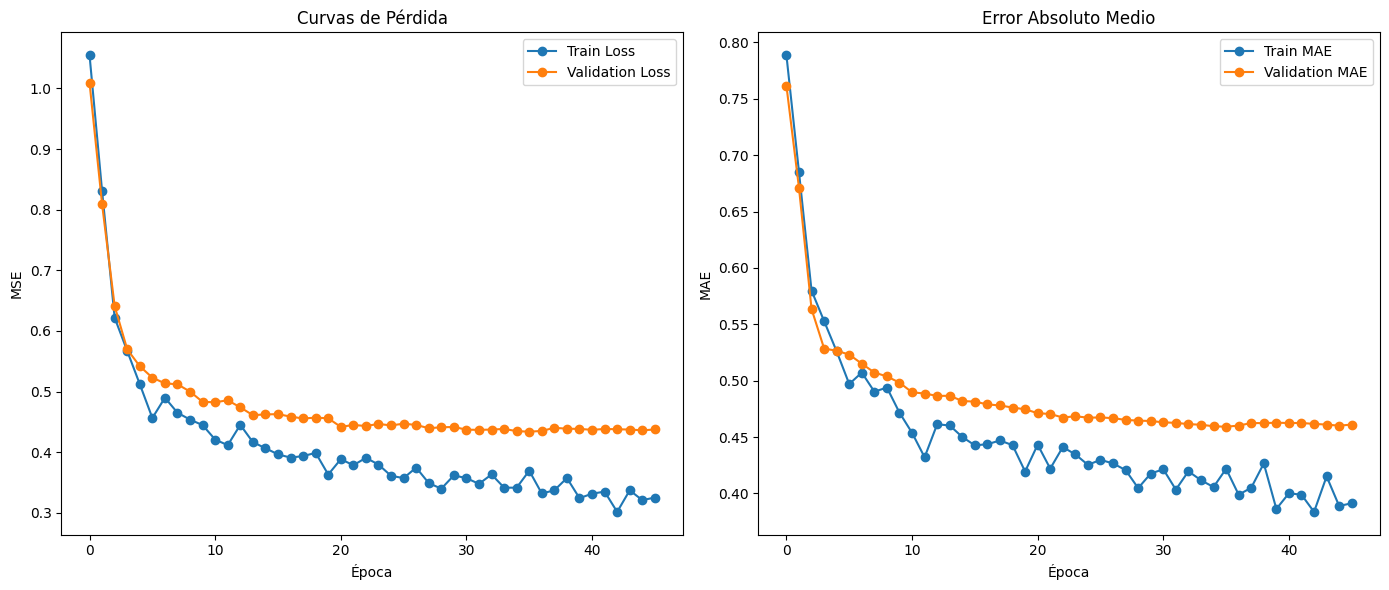

In [104]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Definir callbacks adicionales para un entrenamiento más robusto

# EarlyStopping para detener el entrenamiento si no mejora el val_loss
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau para reducir la tasa de aprendizaje si el val_loss se estabiliza
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,       # reduce la tasa de aprendizaje a la mitad
    patience=5,       # espera 5 épocas sin mejora antes de reducir
    min_lr=1e-6,
    verbose=1
)

# ModelCheckpoint para guardar el modelo con el mejor desempeño en validación
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',  # archivo donde se guardarán los pesos
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Entrenar el modelo
history = model.fit(
    X_train_processed, y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Visualizar el proceso de entrenamiento
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Curvas de Pérdida')
plt.xlabel('Época')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', marker='o')
plt.plot(history.history['val_mae'], label='Validation MAE', marker='o')
plt.title('Error Absoluto Medio')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


### 4.3 Evaluación del Modelo

 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Métricas en entrenamiento:
MSE: 863697436672.00
RMSE: 929353.24
RMSE (%): 19.75%
MAE: 634577.31
R²: 0.72


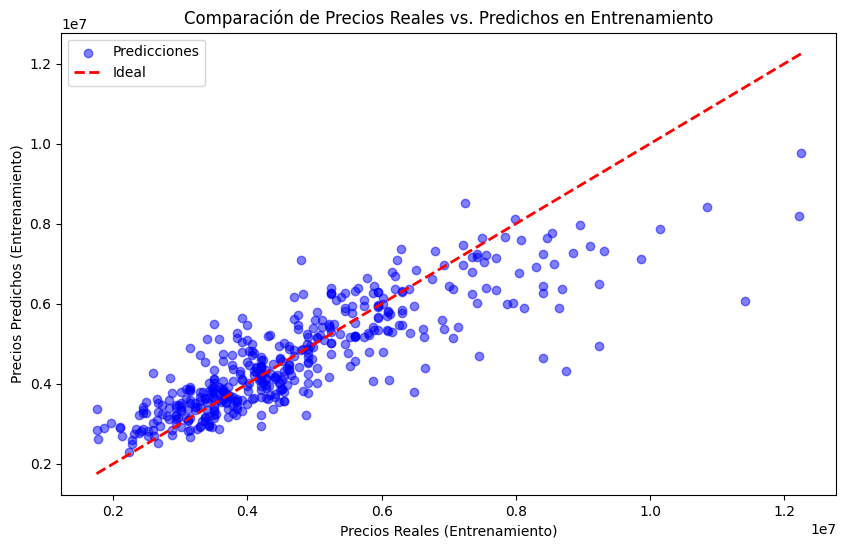

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predicciones sobre el conjunto de entrenamiento
y_train_pred_scaled = model.predict(X_train_processed)
# Invertir el escalado para recuperar los valores log-transformados
y_train_pred_log = y_scaler.inverse_transform(y_train_pred_scaled)
# Aplicar la transformación inversa del log (de log1p a precio original)
y_train_pred = np.expm1(y_train_pred_log)

# Valores reales (en escala original)
y_train_true = y_train.values.reshape(-1, 1)

# Calcular métricas en el conjunto de entrenamiento
mse_train = mean_squared_error(y_train_true, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_true, y_train_pred)
r2_train = r2_score(y_train_true, y_train_pred)
rmse_train_percent = (rmse_train / np.mean(y_train_true)) * 100

print("Métricas en entrenamiento:")
print(f"MSE: {mse_train:.2f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"RMSE (%): {rmse_train_percent:.2f}%")
print(f"MAE: {mae_train:.2f}")
print(f"R²: {r2_train:.2f}")

# Visualizar predicciones vs. valores reales en entrenamiento
plt.figure(figsize=(10, 6))
plt.scatter(y_train_true, y_train_pred, alpha=0.5, color='blue', label='Predicciones')
plt.plot([y_train_true.min(), y_train_true.max()], [y_train_true.min(), y_train_true.max()], 
         'r--', lw=2, label='Ideal')
plt.xlabel('Precios Reales (Entrenamiento)')
plt.ylabel('Precios Predichos (Entrenamiento)')
plt.title('Comparación de Precios Reales vs. Predichos en Entrenamiento')
plt.legend()
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Métricas en el conjunto de Test:
MSE: 1738148413440.00
RMSE: 1318388.57
RMSE (%): 26.33%
MAE: 1009582.62
R²: 0.66

Comparativa de Precios (primeros 5 registros, Test):
   Precio Real  Precio Predicho
0      4060000       7055089.50
1      6650000       8182301.50
2      3710000       3775801.00
3      6440000       4734249.50
4      2800000       3599769.75


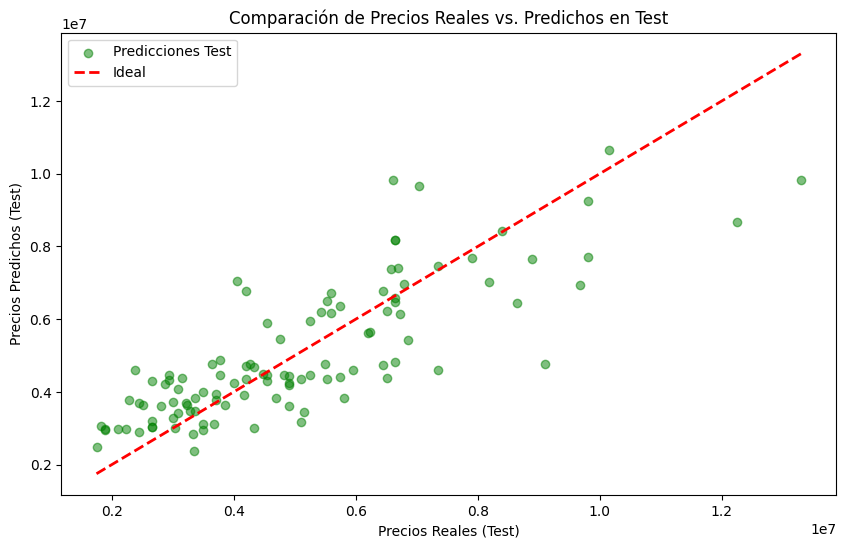

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predicciones sobre el conjunto de test
y_pred_scaled = model.predict(X_test_processed)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_test.values.reshape(-1, 1)

# Calcular métricas en el conjunto de test
mse_test = mean_squared_error(y_true, y_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_true, y_pred)
r2_test = r2_score(y_true, y_pred)
rmse_test_percent = (rmse_test / np.mean(y_true)) * 100

# Imprimir las métricas en forma de tabla
print("Métricas en el conjunto de Test:")
print(f"MSE: {mse_test:.2f}")
print(f"RMSE: {rmse_test:.2f}")
print(f"RMSE (%): {rmse_test_percent:.2f}%")
print(f"MAE: {mae_test:.2f}")
print(f"R²: {r2_test:.2f}")

# Crear un DataFrame para la comparativa de precios
import pandas as pd
df_comparativa_test = pd.DataFrame({
    'Precio Real': y_true.flatten(),
    'Precio Predicho': y_pred.flatten()
})
print("\nComparativa de Precios (primeros 5 registros, Test):")
print(df_comparativa_test.head())

# Visualizar la comparativa mediante un gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5, color='green', label='Predicciones Test')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2, label='Ideal')
plt.xlabel('Precios Reales (Test)')
plt.ylabel('Precios Predichos (Test)')
plt.title('Comparación de Precios Reales vs. Predichos en Test')
plt.legend()
plt.show()


## 5. Optimización del Modelo
### 5.1 Ajuste de Hiperparámetros 

In [107]:
import tensorflow as tf

def build_model_with_hyperparams(neurons_layer1, neurons_layer2, learning_rate):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(neurons_layer1, activation='relu', input_shape=(num_features,)),
        tf.keras.layers.Dense(neurons_layer2, activation='relu'),
        tf.keras.layers.Dropout(0.2),  # Regularización para prevenir overfitting
        tf.keras.layers.Dense(1)       # Capa de salida para regresión
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Definir las configuraciones a probar (neurons_layer1, neurons_layer2, learning_rate)
param_grid = [
    (128, 64, 0.001),
    (64, 32, 0.001),
    (32, 16, 0.001),
    (64, 32, 0.0001)
]

results = []

# Bucle de búsqueda de hiperparámetros
for params in param_grid:
    neurons_layer1, neurons_layer2, lr = params
    print(f"Entrenando modelo con parámetros: {params}")
    
    model = build_model_with_hyperparams(neurons_layer1, neurons_layer2, lr)
    
    history = model.fit(
        X_train_processed, y_train_scaled,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        verbose=0,
        callbacks=[early_stopping]  # Usamos el callback definido anteriormente
    )
    
    # Obtener el mejor valor de val_loss durante el entrenamiento
    val_loss = min(history.history['val_loss'])
    
    results.append({
        'params': params,
        'val_loss': val_loss
    })
    
    print(f"Parámetros: {params}, Val Loss: {val_loss:.4f}")
    
    # Limpiar la sesión para liberar recursos antes de la siguiente iteración
    tf.keras.backend.clear_session()

# Identificar la mejor configuración basada en la menor pérdida en validación
best_params = min(results, key=lambda x: x['val_loss'])['params']
print(f"Mejor configuración: {best_params}")


Entrenando modelo con parámetros: (128, 64, 0.001)


c:\Users\Alumno_AI\.conda\envs\house_model\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Restoring model weights from the end of the best epoch: 45.
Parámetros: (128, 64, 0.001), Val Loss: 0.3791
Entrenando modelo con parámetros: (64, 32, 0.001)
Epoch 47: early stopping
Restoring model weights from the end of the best epoch: 37.
Parámetros: (64, 32, 0.001), Val Loss: 0.3997
Entrenando modelo con parámetros: (32, 16, 0.001)
Restoring model weights from the end of the best epoch: 48.
Parámetros: (32, 16, 0.001), Val Loss: 0.3988
Entrenando modelo con parámetros: (64, 32, 0.0001)
Restoring model weights from the end of the best epoch: 50.
Parámetros: (64, 32, 0.0001), Val Loss: 0.5066
Mejor configuración: (128, 64, 0.001)


### 5.2 Modelo Optimizado Final

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.8751 - mae: 0.7481 - val_loss: 0.6856 - val_mae: 0.6662
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5761 - mae: 0.5992 - val_loss: 0.4677 - val_mae: 0.5069
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3924 - mae: 0.4785 - val_loss: 0.4185 - val_mae: 0.4768
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3521 - mae: 0.4572 - val_loss: 0.3968 - val_mae: 0.4673
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3406 - mae: 0.4425 - val_loss: 0.3773 - val_mae: 0.4573
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2561 - mae: 0.3920 - val_loss: 0.3773 - val_mae: 0.4519
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3153 - mae: 0.4180 - val_loss: 0.3805 - val_mae: 0.4559
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2532 - mae: 0.3873 - val_loss: 0.3832 - val_mae: 0.4606
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.23

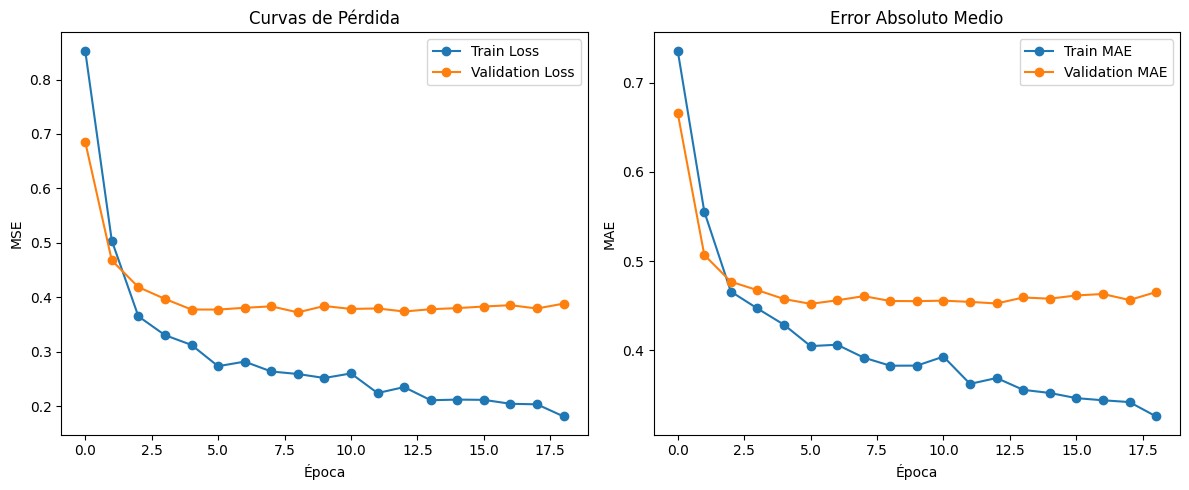

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
MSE Final: 1813780627456.00
RMSE Final: 1346766.73
MAE Final: 991513.38
R² Final: 0.64


In [108]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Construir el modelo final con los mejores parámetros
neurons_layer1, neurons_layer2, lr = best_params
final_model = build_model_with_hyperparams(neurons_layer1, neurons_layer2, lr)

# Entrenar el modelo final
final_history = final_model.fit(
    X_train_processed, y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Visualizar el proceso de entrenamiento
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(final_history.history['loss'], label='Train Loss', marker='o')
plt.plot(final_history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Curvas de Pérdida')
plt.xlabel('Época')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(final_history.history['mae'], label='Train MAE', marker='o')
plt.plot(final_history.history['val_mae'], label='Validation MAE', marker='o')
plt.title('Error Absoluto Medio')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluar el modelo final en el conjunto de prueba
y_pred_final_scaled = final_model.predict(X_test_processed)
# Invertir la transformación del escalador (log-scale)
y_pred_final_log = y_scaler.inverse_transform(y_pred_final_scaled)
# Invertir la transformación logarítmica para obtener los precios originales
y_pred_final = np.expm1(y_pred_final_log)

# Valores reales en el conjunto de prueba
y_true = y_test.values.reshape(-1, 1)

# Calcular métricas finales
mse_final = mean_squared_error(y_true, y_pred_final)
rmse_final = np.sqrt(mse_final)
mae_final = mean_absolute_error(y_true, y_pred_final)
r2_final = r2_score(y_true, y_pred_final)

print(f"MSE Final: {mse_final:.2f}")
print(f"RMSE Final: {rmse_final:.2f}")
print(f"MAE Final: {mae_final:.2f}")
print(f"R² Final: {r2_final:.2f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Métricas en entrenamiento:
MSE: 786879152128.00
RMSE: 887062.09
RMSE (%): 18.85%
MAE: 614011.62
R²: 0.74


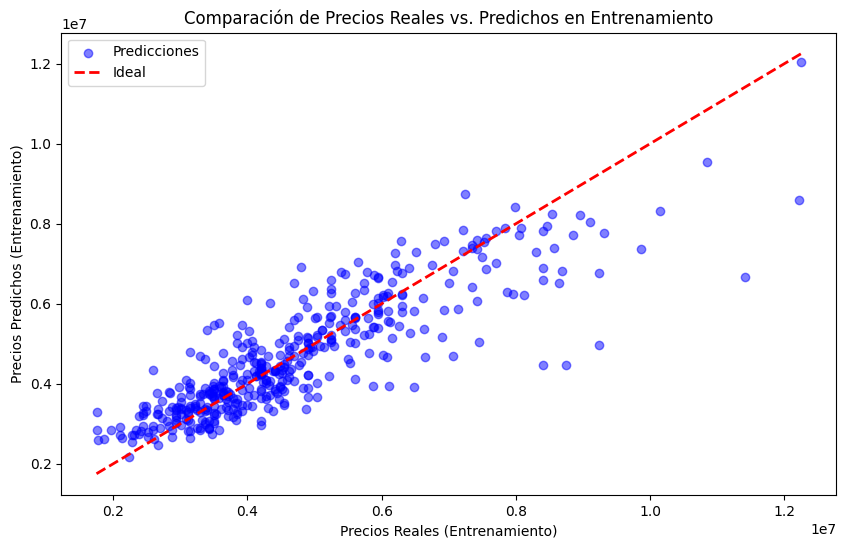

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predicciones sobre el conjunto de entrenamiento
y_train_pred_scaled = final_model.predict(X_train_processed)
# Invertir el escalado para recuperar la escala logarítmica
y_train_pred_log = y_scaler.inverse_transform(y_train_pred_scaled)
# Aplicar la transformación inversa del log (de log1p a precio original)
y_train_pred = np.expm1(y_train_pred_log)

# Valores reales en el conjunto de entrenamiento
y_train_true = y_train.values.reshape(-1, 1)

# Calcular métricas en el conjunto de entrenamiento
mse_train = mean_squared_error(y_train_true, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_true, y_train_pred)
r2_train = r2_score(y_train_true, y_train_pred)
rmse_train_percent = (rmse_train / np.mean(y_train_true)) * 100

print("Métricas en entrenamiento:")
print(f"MSE: {mse_train:.2f}")
print(f"RMSE: {rmse_train:.2f}")
print(f"RMSE (%): {rmse_train_percent:.2f}%")
print(f"MAE: {mae_train:.2f}")
print(f"R²: {r2_train:.2f}")

# Visualizar predicciones vs. valores reales en entrenamiento
plt.figure(figsize=(10, 6))
plt.scatter(y_train_true, y_train_pred, alpha=0.5, color='blue', label='Predicciones')
plt.plot([y_train_true.min(), y_train_true.max()],
         [y_train_true.min(), y_train_true.max()],
         'r--', lw=2, label='Ideal')
plt.xlabel('Precios Reales (Entrenamiento)')
plt.ylabel('Precios Predichos (Entrenamiento)')
plt.title('Comparación de Precios Reales vs. Predichos en Entrenamiento')
plt.legend()
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Métricas en el conjunto de Test:
MSE: 1584617750528.00
RMSE: 1258816.01
RMSE (%): 25.14%
MAE: 913791.25
R²: 0.69

Comparativa de Precios (primeros 5 registros, Test):
   Precio Real  Precio Predicho
0      4060000       5460870.50
1      6650000       7832731.50
2      3710000       3678715.00
3      6440000       4527128.50
4      2800000       3657874.25


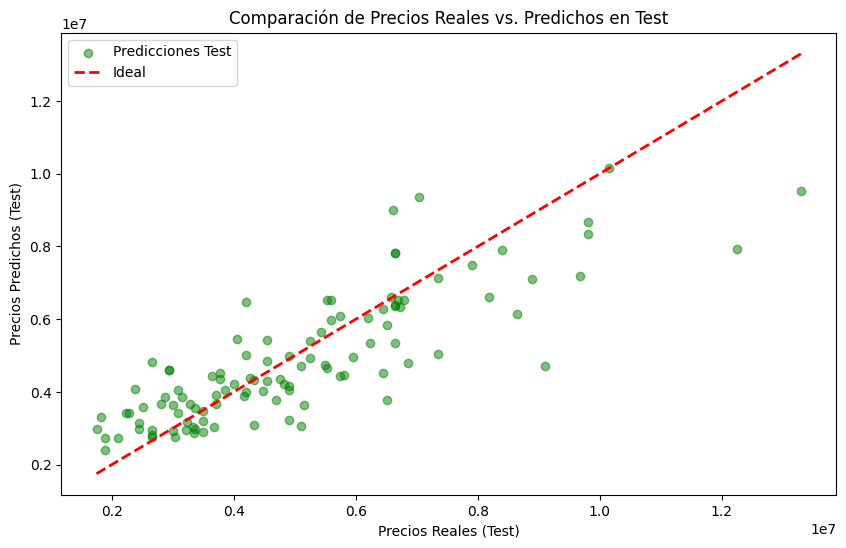

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predicciones sobre el conjunto de test
y_pred_scaled = final_model.predict(X_test_processed)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_test.values.reshape(-1, 1)

# Calcular métricas en el conjunto de test
mse_test = mean_squared_error(y_true, y_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_true, y_pred)
r2_test = r2_score(y_true, y_pred)
rmse_test_percent = (rmse_test / np.mean(y_true)) * 100

# Imprimir las métricas en forma de tabla
print("Métricas en el conjunto de Test:")
print(f"MSE: {mse_test:.2f}")
print(f"RMSE: {rmse_test:.2f}")
print(f"RMSE (%): {rmse_test_percent:.2f}%")
print(f"MAE: {mae_test:.2f}")
print(f"R²: {r2_test:.2f}")

# Crear un DataFrame para la comparativa de precios
import pandas as pd
df_comparativa_test = pd.DataFrame({
    'Precio Real': y_true.flatten(),
    'Precio Predicho': y_pred.flatten()
})
print("\nComparativa de Precios (primeros 5 registros, Test):")
print(df_comparativa_test.head())

# Visualizar la comparativa mediante un gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5, color='green', label='Predicciones Test')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2, label='Ideal')
plt.xlabel('Precios Reales (Test)')
plt.ylabel('Precios Predichos (Test)')
plt.title('Comparación de Precios Reales vs. Predichos en Test')
plt.legend()
plt.show()

### 5.3 Análisis de Características e Interpretabilidad

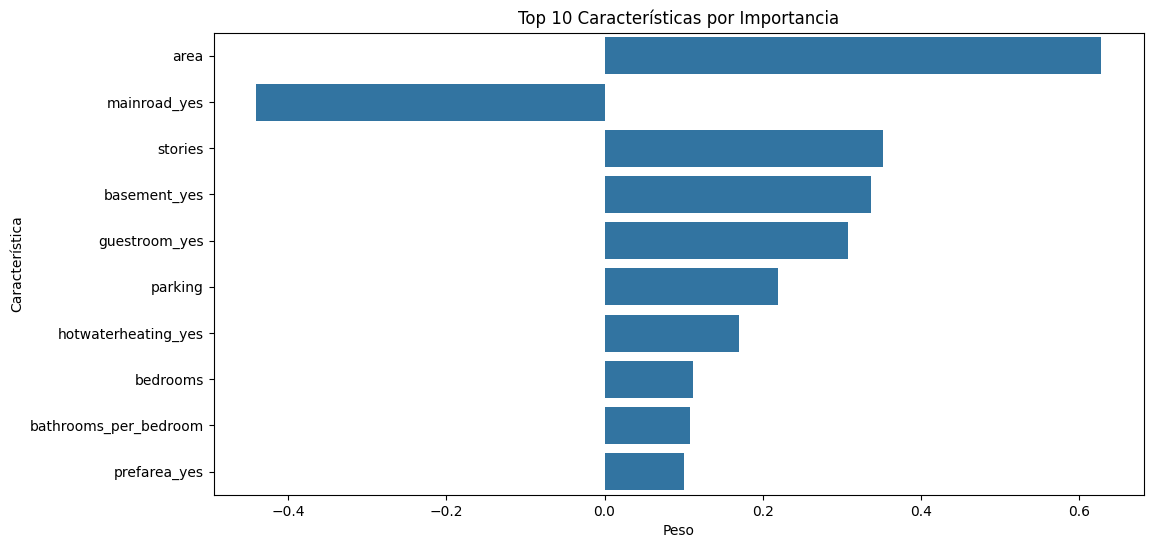

In [111]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Construir un modelo simple (regresión lineal sin sesgo) para análisis de características
simple_model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=(num_features,), use_bias=False)
])

simple_model.compile(optimizer='adam', loss='mse')
simple_model.fit(X_train_processed, y_train_scaled, epochs=50, batch_size=32, verbose=0)

# Obtener los pesos del modelo (cada peso indica la importancia en la escala del modelo lineal)
feature_weights = simple_model.get_weights()[0].flatten()

# Extraer nombres de características tras el preprocesamiento.
# En nuestro preprocessor tenemos cuatro grupos: 'cont' (continuas), 'disc' (discretas), 'cat' (categóricas) y 'ord' (ordinales).
feature_names = []
for name, transformer, features in preprocessor.transformers_:
    if name in ['cont', 'disc']:
        # Para las variables continuas y discretas, usamos directamente los nombres
        feature_names.extend(features)
    elif name == 'cat':
        # Para variables categóricas (OneHotEncoder con drop='first' en variables binarias)
        # Se genera una única columna por variable, que representa la condición 'yes'
        for feature in features:
            feature_names.append(f"{feature}_yes")
    elif name == 'ord':
        # Para variables ordinales, cada variable se codifica en una única columna
        feature_names.extend(features)

# En caso de que OneHotEncoder haya generado más de una columna por variable (no es el caso actual),
# se intenta obtener los nombres directamente del transformador.
if len(feature_names) < len(feature_weights):
    try:
        cat_transformer = preprocessor.named_transformers_['cat']
        cat_feature_names = list(cat_transformer.named_steps['onehot'].get_feature_names_out(categorical_features))
        # Reconstruir la lista completa: continuas, discretas, luego las de OneHotEncoder y ordinales
        feature_names = []
        feature_names.extend(continuous_features)
        feature_names.extend(discrete_features)
        feature_names.extend(cat_feature_names)
        feature_names.extend(ordinal_features)
    except Exception as e:
        feature_names = feature_names[:len(feature_weights)]
else:
    # En caso de que se hayan generado más nombres de los que corresponden a los pesos, truncar la lista
    feature_names = feature_names[:len(feature_weights)]

# Crear un DataFrame para visualizar la importancia de las características
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Weight': feature_weights
})

# Ordenar por el valor absoluto del peso y quedarse con las 10 características más relevantes
importance_df['AbsWeight'] = importance_df['Weight'].abs()
importance_df = importance_df.sort_values('AbsWeight', ascending=False).head(10)

# Visualizar la importancia de las características mediante un gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x='Weight', y='Feature', data=importance_df)
plt.title('Top 10 Características por Importancia')
plt.xlabel('Peso')
plt.ylabel('Característica')
plt.show()


### 5.4 Implementación para Predicciones

In [113]:
import numpy as np

def predict_house_price(new_data, preprocessor, model, y_scaler):
    """
    Predice el precio de una casa con nuevos datos,
    replicando la ingeniería de características y
    las transformaciones aplicadas en el entrenamiento.
    
    Args:
        new_data (pd.DataFrame): DataFrame con una o más filas que describan casas nuevas.
        preprocessor (ColumnTransformer): Pipeline que transformó X (creado con fit_transform).
        model (tf.keras.Model): Modelo entrenado para predecir el precio.
        y_scaler (sklearn Scaler): Scaler usado para el objetivo (y).
    
    Returns:
        np.ndarray: Vector/array con los precios predichos en la escala original.
    """
    # -----------------------------------------------------------------------------------
    # 1) Replicar la ingeniería de características si NO se hizo dentro del pipeline.
    #    (Si la creación de columnas "area_per_bedroom", etc. estaba fuera del pipeline,
    #     debemos hacerlo aquí para que el pipeline tenga las mismas columnas.)
    # -----------------------------------------------------------------------------------
    if 'area_per_bedroom' not in new_data.columns:
        new_data['area_per_bedroom'] = new_data['area'] / (new_data['bedrooms'] + 1)
    if 'bathrooms_per_bedroom' not in new_data.columns:
        new_data['bathrooms_per_bedroom'] = new_data['bathrooms'] / (new_data['bedrooms'] + 1)
    if 'area_per_story' not in new_data.columns:
        new_data['area_per_story'] = new_data['area'] / (new_data['stories'] + 1)

    # -----------------------------------------------------------------------------------
    # 2) Aplicar el pipeline de preprocesamiento a los datos nuevos.
    # -----------------------------------------------------------------------------------
    new_data_processed = preprocessor.transform(new_data)

    # -----------------------------------------------------------------------------------
    # 3) Realizar la predicción en el espacio "scaled log" (salida del modelo).
    # -----------------------------------------------------------------------------------
    prediction_scaled = model.predict(new_data_processed)

    # -----------------------------------------------------------------------------------
    # 4) Invertir la escala para volver al espacio logarítmico original.
    # -----------------------------------------------------------------------------------
    prediction_log = y_scaler.inverse_transform(prediction_scaled)

    # -----------------------------------------------------------------------------------
    # 5) Invertir la transformación logarítmica (log1p) para obtener el precio real.
    # -----------------------------------------------------------------------------------
    prediction_price = np.expm1(prediction_log)

    return prediction_price.flatten()

# Ejemplo de uso con una nueva casa
new_house = pd.DataFrame({
    'area': [5000],
    'bedrooms': [3],
    'bathrooms': [2],
    'stories': [2],
    'mainroad': ['yes'],
    'guestroom': ['no'],
    'basement': ['yes'],
    'hotwaterheating': ['no'],
    'airconditioning': ['yes'],
    'parking': [1],
    'prefarea': ['yes'],
    'furnishingstatus': ['furnished']
})

predicted_price = predict_house_price(new_house, preprocessor, final_model, y_scaler)
print(f"Precio predicho para la nueva casa: {predicted_price[0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Precio predicho para la nueva casa: 7326780.50


## 6. Evaluacion, Guardado y carga del modelo
### 6.1 Guardado

In [91]:
# Guardar el modelo
tf.saved_model.save(model, 'house_price_model_saved_model_v2')

# Cargar el modelo
loaded_model = tf.saved_model.load('house_price_model_saved_model')

# Para hacer predicciones, necesitas obtener la función de inferencia del modelo cargado
infer = loaded_model.signatures["serving_default"]


INFO:tensorflow:Assets written to: house_price_model_saved_model_v2\assets


INFO:tensorflow:Assets written to: house_price_model_saved_model_v2\assets


### 6.2 Validación Cruzada para Evaluación Robusta

In [92]:
from sklearn.model_selection import KFold

# Configurar validación cruzada
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

cv_scores = []

# Función para crear y entrenar modelo
def create_and_train_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(num_features,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Realizar validación cruzada
print("Iniciando validación cruzada...")
fold = 1

X_processed = preprocessor.fit_transform(X)
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

for train_idx, test_idx in kf.split(X_processed):
    X_train_fold, X_test_fold = X_processed[train_idx], X_processed[test_idx]
    y_train_fold, y_test_fold = y_scaled[train_idx], y_scaled[test_idx]
    
    # Crear y entrenar modelo
    fold_model = create_and_train_model()
    fold_model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, verbose=0)
    
    # Evaluar
    y_pred_fold = fold_model.predict(X_test_fold)
    mse_fold = mean_squared_error(y_test_fold, y_pred_fold)
    
    cv_scores.append(mse_fold)
    print(f"Fold {fold}: MSE = {mse_fold:.4f}")
    fold += 1

print(f"Promedio MSE en validación cruzada: {np.mean(cv_scores):.4f}")
print(f"Desviación estándar: {np.std(cv_scores):.4f}")


Iniciando validación cruzada...


c:\Users\Alumno_AI\.conda\envs\house_model\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Fold 1: MSE = 0.4912


c:\Users\Alumno_AI\.conda\envs\house_model\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Fold 2: MSE = 0.4118


c:\Users\Alumno_AI\.conda\envs\house_model\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Fold 3: MSE = 0.2468


c:\Users\Alumno_AI\.conda\envs\house_model\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Fold 4: MSE = 0.2650


c:\Users\Alumno_AI\.conda\envs\house_model\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Fold 5: MSE = 0.3185
Promedio MSE en validación cruzada: 0.3467
Desviación estándar: 0.0923


### 6.3 Carga

In [93]:
import tensorflow as tf

# Cargar el modelo
loaded_model = tf.saved_model.load('house_price_model_saved_model_v2')

# Imprimir las firmas del modelo
print(loaded_model.signatures)


_SignatureMap({'serving_default': <ConcreteFunction (*, inputs: TensorSpec(shape=(None, 12), dtype=tf.float32, name='inputs')) -> Dict[['output_0', TensorSpec(shape=(None, 1), dtype=tf.float32, name='output_0')]] at 0x1BC8AFB2EC0>})


In [94]:
print(loaded_model.signatures['serving_default'].structured_outputs)


{'output_0': TensorSpec(shape=(None, 1), dtype=tf.float32, name='output_0')}


## 7. Inferencia

In [95]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import pickle
import pandas as pd

# Paso 7: Cargar el modelo usando tf.saved_model
loaded_model = tf.saved_model.load('house_price_model_saved_model_v2')

# Paso 8: Cargar el scaler
with open('scaler.pkl', 'rb') as f:
    loaded_scaler = pickle.load(f)

# Paso 9: Preparar nuevos datos para la predicción
new_data = pd.DataFrame({
    'area': [7420],
    'bedrooms': [4],
    'bathrooms': [2],
    'stories': [3],
    'mainroad': [1],
    'guestroom': [0],
    'basement': [0],
    'hotwaterheating': [0],
    'airconditioning': [1],
    'parking': [2],
    'prefarea': [1],
    'furnishingstatus_semi-furnished': [0],
    'furnishingstatus_unfurnished': [0]
})

# Paso 10: Escalar los nuevos datos
new_data_scaled = loaded_scaler.transform(new_data)

# Paso 11: Obtener la función de inferencia del modelo cargado
infer = loaded_model.signatures["serving_default"]

# Paso 12: Realizar la predicción
prediction = infer(tf.constant(new_data_scaled, dtype=tf.float32))

# Ajusta el nombre de la capa aquí
nombre_capa_salida = list(prediction.keys())[0]  # Obtener el primer nombre de clave
print(nombre_capa_salida)

# Ajusta el nombre de la capa aquí
print(f"Predicción del precio de la vivienda: {prediction[nombre_capa_salida].numpy()[0][0]:.2f}")


InvalidArgumentError: Graph execution error:

Detected at node StatefulPartitionedCall/sequential_46_1/dense_136_1/Relu defined at (most recent call last):
<stack traces unavailable>
Matrix size-incompatible: In[0]: [1,13], In[1]: [12,64]
	 [[{{node StatefulPartitionedCall/sequential_46_1/dense_136_1/Relu}}]] [Op:__inference_signature_wrapper_serving_default_314490]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Comparativa de Precios (primeros 5 registros):
   Precio Real  Precio Predicho
0      4060000       5745694.00
1      6650000       7089096.00
2      3710000       3041608.00
3      6440000       4407813.50
4      2800000       3623888.75

Métricas de Evaluación:
    Métrica         Valor
0       MSE  2.156006e+12
1      RMSE  1.468335e+06
2  RMSE (%)  2.932249e+01
3       MAE  1.099423e+06
4        R²  5.734541e-01


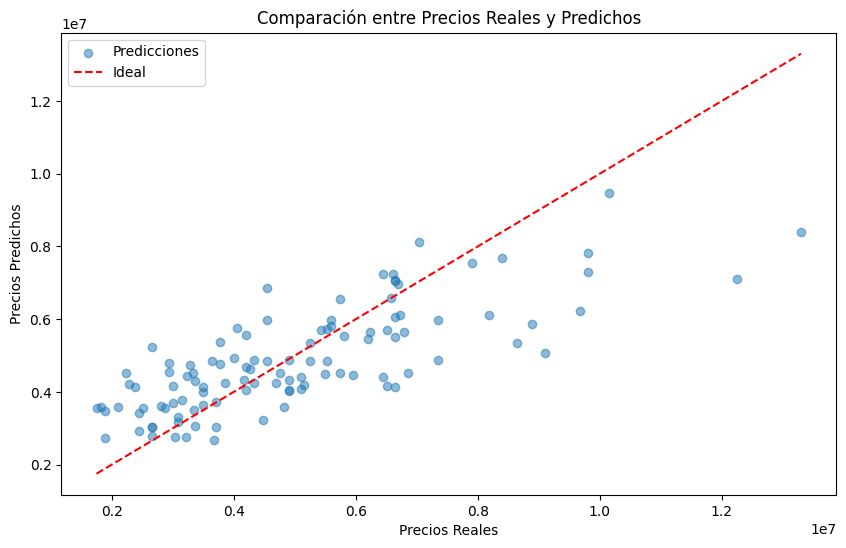

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Cargar el modelo guardado mediante TFSMLayer
inference_layer = tf.keras.layers.TFSMLayer('house_price_model_saved_model_v2', call_endpoint='serving_default')
inputs = tf.keras.Input(shape=(X_test_processed.shape[1],))
outputs = inference_layer(inputs)
loaded_model = tf.keras.Model(inputs, outputs)

# Realizar la predicción en el conjunto de test
y_pred_scaled = loaded_model.predict(X_test_processed)

# Si la salida es un diccionario, extraemos el primer valor (suponiendo que sea el único)
if isinstance(y_pred_scaled, dict):
    y_pred_scaled = list(y_pred_scaled.values())[0]

# Revertir la transformación para obtener los precios en la escala original
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_test.values.reshape(-1, 1)

# Crear un DataFrame para comparar los precios reales y predichos
df_comparativa = pd.DataFrame({
    'Precio Real': y_true.flatten(),
    'Precio Predicho': y_pred.flatten()
})
print("Comparativa de Precios (primeros 5 registros):")
print(df_comparativa.head())

# Calcular métricas de evaluación
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
rmse_percent = (rmse / np.mean(y_true)) * 100

# Imprimir las métricas en forma de tabla
metrics_df = pd.DataFrame({
    'Métrica': ['MSE', 'RMSE', 'RMSE (%)', 'MAE', 'R²'],
    'Valor': [mse, rmse, rmse_percent, mae, r2]
})
print("\nMétricas de Evaluación:")
print(metrics_df)

# Visualizar la comparativa mediante un gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5, label='Predicciones')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Ideal')
plt.xlabel('Precios Reales')
plt.ylabel('Precios Predichos')
plt.title('Comparación entre Precios Reales y Predichos')
plt.legend()
plt.show()
